# Additional regressors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [4]:
URL = 'https://raw.githubusercontent.com/PacktPublishing/Forecasting-Time-Series-Data-with-Facebook-Prophet/main/data/divvy_daily.csv'
df = pd.read_csv(URL)
# df = df[['date', 'rides']]
# df['date'] = pd.to_datetime(df['date'])
# df.columns = ['ds', 'y']

## Adding binary regressors

In [5]:
print(df.groupby('weather')['weather'].count())

weather
clear             41
cloudy          1346
not clear          2
rain or snow      69
Name: weather, dtype: int64


In [6]:
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y', 'temp', 'weather']
df = pd.get_dummies(df, columns=['weather'], prefix='',
                    prefix_sep='')

In [7]:
df.head()

,ds,y,temp,clear,cloudy,not clear,rain or snow
0,2014-01-01,95,19.483158,0,0,0,1
1,2014-01-02,111,16.833333,0,0,0,1
2,2014-01-03,6,-5.633333,1,0,0,0
3,2014-01-04,181,30.007735,0,0,0,1
4,2014-01-05,32,16.756250,0,0,0,1


We must make one add_regressor call for each additional regressor but note that we 
are leaving the regressor for cloudy out. For Prophet to get accurate forecast results, this 
isn't strictly necessary. However, because including all four binary columns will introduce 
**multicollinearity**, this makes interpreting the individual effect of each condition difficult, 
so we will exclude one of them. However, Prophet is fairly robust to multicollinearity in 
additional regressors, so it shouldn't affect your final results significantly.


In [8]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)
model.add_regressor(name='clear',
                    prior_scale=10,
                    standardize='auto',
                    mode='multiplicative')
model.add_regressor('not clear')
model.add_regressor('rain or snow')

In [9]:
from datetime import timedelta
# Remove final 2 weeks of training data
train = df[df['ds'] < df['ds'].max() - timedelta(weeks=2)]

In [10]:
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -104.88


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2736.51   0.000240589       70.4388      0.8556      0.8556      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       2736.93    0.00357559        355.89   3.635e-05       0.001      179  LS failed, Hessian reset 
     159       2737.38   8.61591e-05       78.8514   8.273e-07       0.001      277  LS failed, Hessian reset 
     199       2737.39   2.62963e-06       95.3693      0.3545           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2737.47   1.78432e-06       62.7565           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       2737.47   1.11114e-06       64.4447      0.4573      0.4573      484   
Optimization terminated normally: 
  Convergence detected: rel

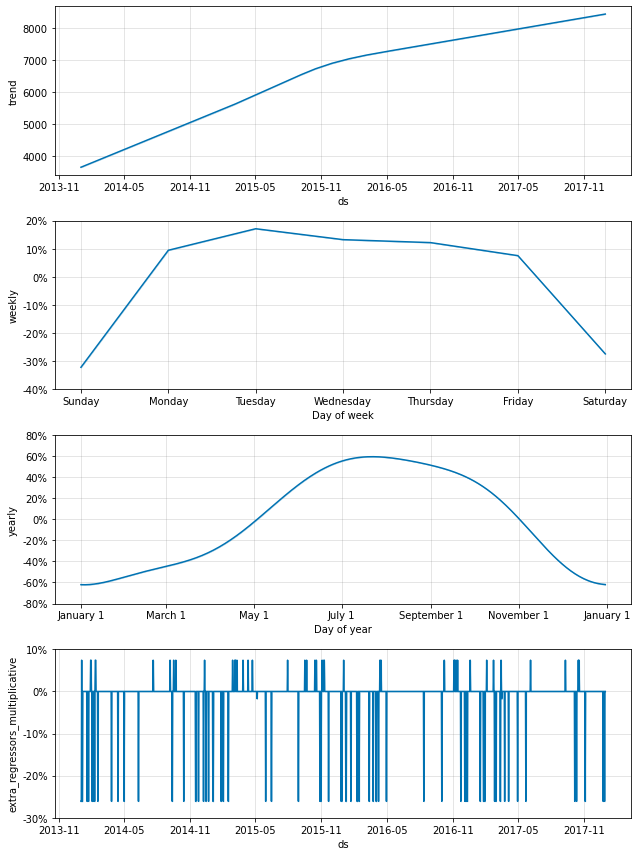

In [11]:
future = model.make_future_dataframe(periods=14)
future['clear'] = df['clear']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
plt.show()

## Adding continuous regressors

In [12]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)
model.add_regressor('temp')
model.add_regressor('clear')
model.add_regressor('not clear')
model.add_regressor('rain or snow')
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -104.88


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2943.3     0.0013221       78.8372      0.3442           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2944.21   2.34217e-05       83.1576      0.3081      0.3081      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2944.24    9.7276e-05        90.261           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2944.25    1.1351e-05       96.7433           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2944.27   0.000102397       85.7384           1           1      625   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     538     

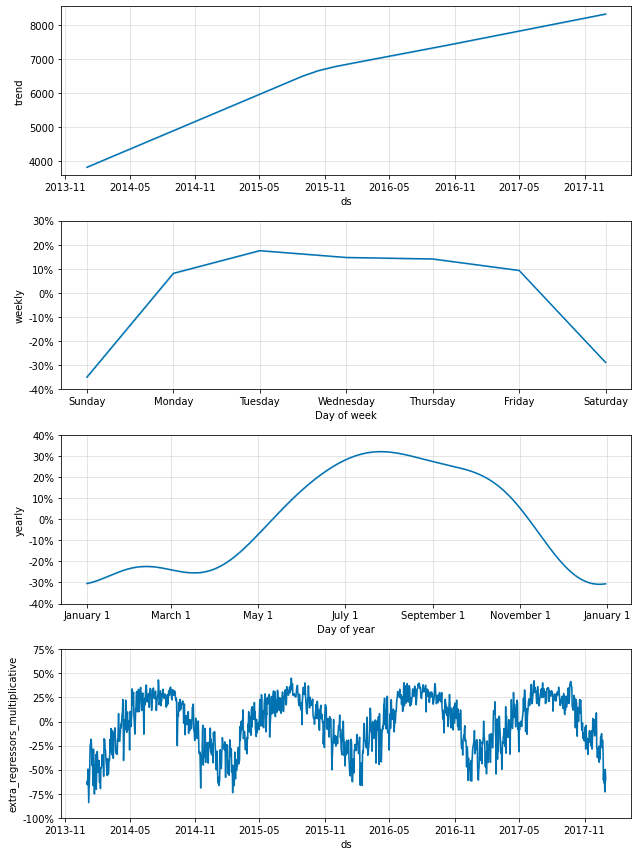

In [13]:
future = model.make_future_dataframe(periods=14)
future['temp'] = df['temp']
future['clear'] = df['clear']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
plt.show() 

## Interpreting the regressor coefficients

In [16]:
from prophet.utilities import regressor_coefficients

regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,temp,multiplicative,53.423706,0.012298,0.012298,0.012298
1,clear,multiplicative,0.000000,0.110569,0.110569,0.110569
2,not clear,multiplicative,0.000000,-0.035873,-0.035873,-0.035873
3,rain or snow,multiplicative,0.000000,-0.206050,-0.206050,-0.206050


The `coef` column denotes the expected value of the coefficient. That is, the expected impact on `'y'` of a unit increase in the regressor. In the preceding DataFrame, the `coef` for `temp` is `0.012282`. This coefficient tells us that **for every degree higher than the center** (53.4, in this case), the expected effect on ridership will be `0.012282`, or a `1.2%` increase.

For the `rain` or `snow` row, which is a binary regressor, it tells us that on those rainy 
or snowy days, then ridership will be down `20.6%` compared to `cloudy` days, **as that was the regressor we left out**. Had we included all four weather conditions, to interpret this 
value, you would say ridership would be down `20.6%` compared to the value predicted 
for the same day if modeled without including weather conditions.

Finally, the columns for `'coef_lower'` and `'coef_upper'` indicate the lower and 
upper bounds, respectively, of the uncertainty interval around the coefficient. They are 
only of interest if `mcmc_samples` is set to a value greater than zero. **Markov chain** 
**Monte Carlo** samples, or **MCMC** samples, is a topic you'll learn about, 
*Uncertainty Intervals*. If `mcmc_samples` is left at the default value, as in these examples, 
`'coef_lower'` and `'coef_upper'` will be equal to coef.

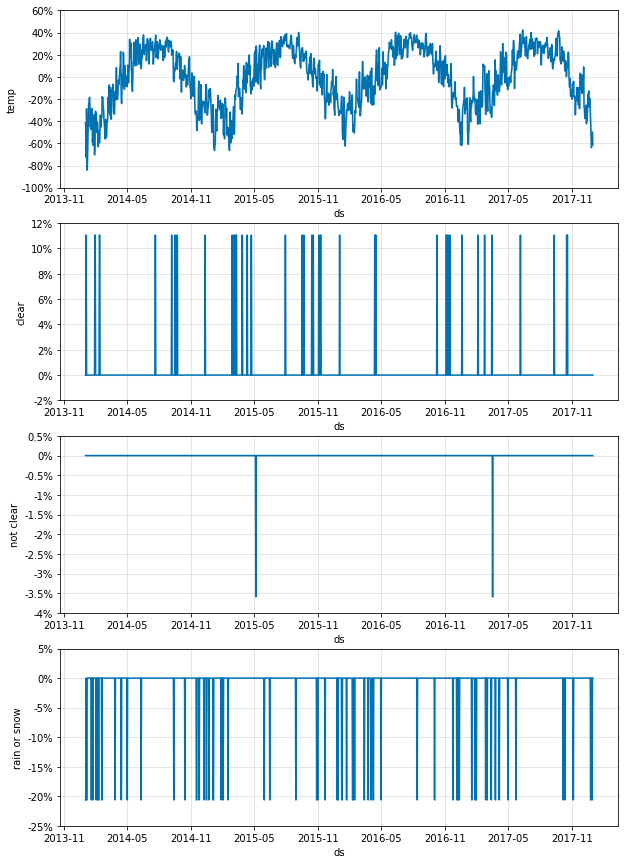

In [18]:
from prophet.plot import plot_forecast_component
fig, axes = plt.subplots(
                        len(regressor_coefficients(model)),
                        figsize=(10, 15))
for i, regressor in enumerate(
    regressor_coefficients(model)['regressor']):
    plot_forecast_component(model,
                            forecast,
                            regressor,
                            axes[i])
plt.show()